Plot Q-score~Relative position on reads

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pysam

# 
path_workdir = Path("/home/b05b01002/HDD/project_nanoprep_re")
names = [
    "egr-109-bio1",
    "egr-109-bio2",
    "lch-109-bio1",
    "lch-109-bio2",
    "ptr-109-bio1",
    "ptr-109-bio2",
    "ptr-111-bio1",
    "ont-10x-human",
    "ont-visium-mouse",
    "mouse-retina-subset1",
    "mouse-retina-subset2"
]
accuracies = [
    "sup",
    "hac",
    "fast"
]

# mean_q
def mean_q(qscore_array):
    q2phred = {q: 10 ** (q / -10) for q in range(0, 129)}
    phred = [q2phred[i] for i in qscore_array]
    mean_phred = sum(phred) / len(phred)
    mean_q = -10 * np.log10(mean_phred)
    return mean_q


Basecalled samples

In [2]:
first200 = {}
last200 = {}
n_bases = 200
for name in names[:-2]:
    for accuracy in accuracies:
        filename = path_workdir / f"outputs/Basecalling/aggregate_fastq/{name}_{accuracy}.fq"
        first200[f"{name}_{accuracy}"] = []
        last200[f"{name}_{accuracy}"] = []
        with pysam.FastxFile(filename) as fh:
            for entry in fh:
                quality_arrary = entry.get_quality_array()
                first200[f"{name}_{accuracy}"].append(quality_arrary[:n_bases])
                last200[f"{name}_{accuracy}"].append(quality_arrary[-n_bases:])

Pre-called samples

In [3]:
first200["mouse-retina-subset1_sup"] = []
last200["mouse-retina-subset1_sup"] = []
filename = path_workdir / "rawdata/rui-chen-lab/Ms_bulk_subset1.fastq.gz"
with pysam.FastxFile(filename) as fh:
    for entry in fh:
        quality_arrary = entry.get_quality_array()
        first200["mouse-retina-subset1_sup"].append(quality_arrary[:n_bases])
        last200["mouse-retina-subset1_sup"].append(quality_arrary[-n_bases:])

In [4]:
first200["mouse-retina-subset2_sup"] = []
last200["mouse-retina-subset2_sup"] = []
filename = path_workdir / "rawdata/rui-chen-lab/Ms_bulk_subset2.fastq.gz"
with pysam.FastxFile(filename) as fh:
    for entry in fh:
        quality_arrary = entry.get_quality_array()
        first200["mouse-retina-subset2_sup"].append(quality_arrary[:n_bases])
        last200["mouse-retina-subset2_sup"].append(quality_arrary[-n_bases:])

Calculate Mean Q at each position

In [5]:
data = pd.DataFrame()
for name_accuracy, qscore_lists in first200.items():
    mean_q_by_pos = pd.DataFrame(qscore_lists).apply(lambda x: mean_q(x.dropna()), axis=0)
    mean_q_by_pos = pd.DataFrame({"mean_q": mean_q_by_pos})
    mean_q_by_pos["name_accuracy"] = name_accuracy
    mean_q_by_pos["name"], mean_q_by_pos["accuracy"] = name_accuracy.split("_")
    mean_q_by_pos["pos"] = [i + 1 for i in mean_q_by_pos.index]
    data = pd.concat([data, mean_q_by_pos])

In [6]:
data_last = pd.DataFrame()
for name_accuracy, qscore_lists in last200.items():
    mean_q_by_pos = pd.DataFrame(qscore_lists).apply(lambda x: mean_q(x.dropna()), axis=0)
    mean_q_by_pos = pd.DataFrame({"mean_q": mean_q_by_pos})
    mean_q_by_pos["name_accuracy"] = name_accuracy
    mean_q_by_pos["name"], mean_q_by_pos["accuracy"] = name_accuracy.split("_")
    mean_q_by_pos["pos"] = [i + 1 for i in mean_q_by_pos.index]
    data_last = pd.concat([data_last, mean_q_by_pos])

/tmp/ipykernel_897200/3432519169.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(current_labels[::-1])


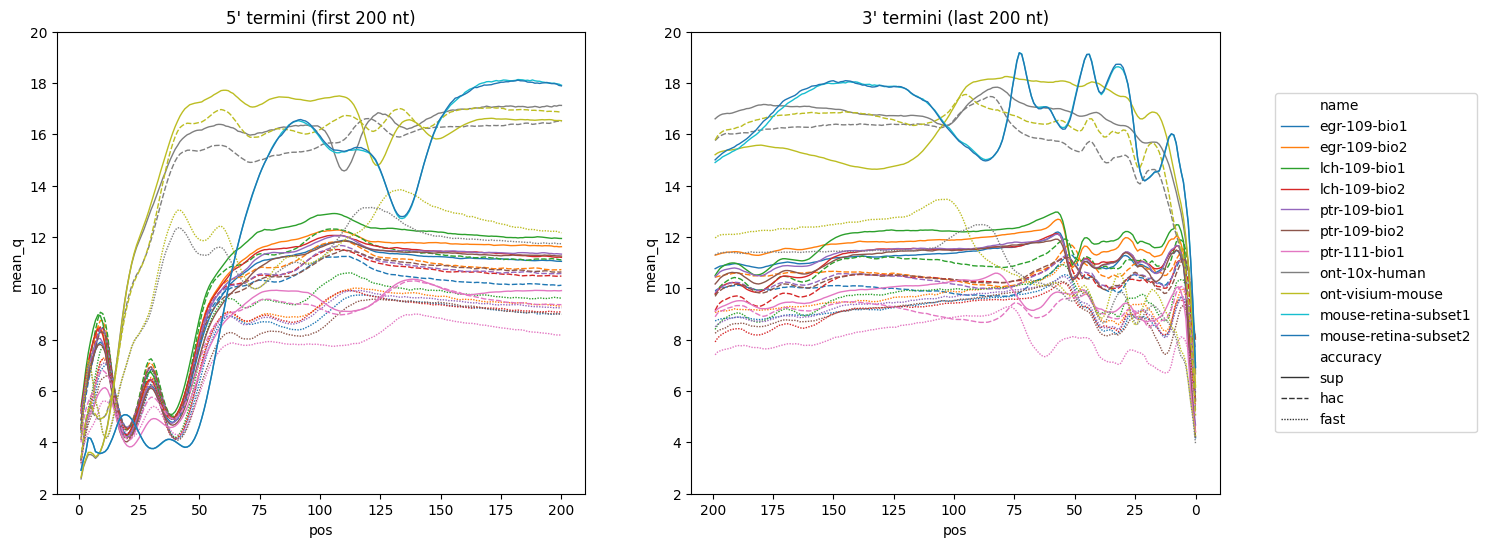

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
linewidth = 1
hue = "name"
hue_members = data[hue].unique()
palette = dict(zip(hue_members, sns.color_palette("tab10", len(hue_members))))
sns.lineplot(
    data=data,
    x="pos",
    y="mean_q",
    hue="name",
    style="accuracy",
    linewidth=linewidth,
    palette=palette,
    errorbar="se",
    legend=False,
    ax=axes[0]
)
sns.lineplot(
    data=data_last,
    x="pos",
    y="mean_q",
    hue="name",
    style="accuracy",
    linewidth=linewidth,
    palette=palette,
    errorbar="se",
    ax=axes[1]
)
current_labels = [label.get_text() for label in axes[1].get_xticklabels()]
axes[1].set_xticklabels(current_labels[::-1])
axes[1].legend(loc="center right", bbox_to_anchor=(1.5, 0.5))
axes[0].set_title("5' termini (first 200 nt)")
axes[1].set_title("3' termini (last 200 nt)")
axes[0].set_ylim(2, 20)
axes[1].set_ylim(2, 20)
fig.savefig("output/mean_q_at_first_n_last_200nt.svg")